# Method 2 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

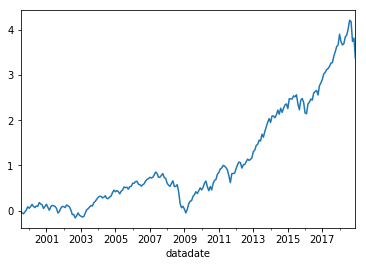

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.087131
2000-12-31    0.009513
2001-12-31   -0.001940
2002-12-31   -0.178421
2003-12-31    0.393418
2004-12-31    0.160363
2005-12-31    0.056608
2006-12-31    0.110561
2007-12-31    0.003896
2008-12-31   -0.359565
2009-12-31    0.370561
2010-12-31    0.200870
2011-12-31    0.014237
2012-12-31    0.184444
2013-12-31    0.398468
2014-12-31    0.107216
2015-12-31    0.009382
2016-12-31    0.126786
2017-12-31    0.220176
2018-12-31   -0.064556
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2419.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.44e-186
Time:                        01:55:13   Log-Likelihood:                 844.67
No. Observations:                 234   AIC:                            -1679.
Df Residuals:                     229   BIC:                            -1662.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.000      5.293      0.000       0.001       0.003
mktrf          0.9575      0.012     77.567      0.000       0.933       0.982
me             0.1687      0.014     11.751      0.000       0.140       0.197
ia             0.1427      0.022      6.539      0.000       0.100       0.186
roe            0.0262      0.019      1.402      0.162      -0.011       0.063
==============================================================================
Omnibus:                       16.447   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.159
Skew:                           0.256   Prob(JB):                     3.14e-09
Kurtosis:                       4.938   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1266.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.74e-155
Time:                        01:55:13   Log-Likelihood:                 844.67
No. Observations:                 234   AIC:                            -1679.
Df Residuals:                     229   BIC:                            -1662.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.309      0.000       0.001       0.003
mktrf          0.9575      0.017     55.544      0.000       0.924       0.991
me             0.1687      0.040      4.206      0.000       0.090       0.247
ia             0.1427      0.046      3.100      0.002       0.052       0.233
roe            0.0262      0.022      1.197      0.231      -0.017       0.069
==============================================================================
Omnibus:                       16.447   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.159
Skew:                           0.256   Prob(JB):                     3.14e-09
Kurtosis:                       4.938   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1339.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.62e-157
Time:                        01:55:13   Log-Likelihood:                 844.67
No. Observations:                 234   AIC:                            -1679.
Df Residuals:                     229   BIC:                            -1662.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.340      0.000       0.001       0.003
mktrf          0.9575      0.017     57.819      0.000       0.925       0.990
me             0.1687      0.038      4.399      0.000       0.094       0.244
ia             0.1427      0.054      2.638      0.008       0.037       0.249
roe            0.0262      0.023      1.124      0.261      -0.019       0.072
==============================================================================
Omnibus:                       16.447   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.159
Skew:                           0.256   Prob(JB):                     3.14e-09
Kurtosis:                       4.938   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2176.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.56e-190
Time:                        01:55:13   Log-Likelihood:                 858.62
No. Observations:                 234   AIC:                            -1705.
Df Residuals:                     228   BIC:                            -1685.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.464      0.000       0.001       0.003
mktrf          0.9734      0.012     83.354      0.000       0.950       0.996
smb            0.2046      0.015     13.280      0.000       0.174       0.235
hml            0.0345      0.018      1.901      0.059      -0.001       0.070
rmw            0.0813      0.021      3.960      0.000       0.041       0.122
cma            0.0802      0.026      3.071      0.002       0.029       0.132
==============================================================================
Omnibus:                       49.672   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.006
Skew:                           0.759   Prob(JB):                     9.19e-47
Kurtosis:                       7.409   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1278.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.55e-164
Time:                        01:55:13   Log-Likelihood:                 858.62
No. Observations:                 234   AIC:                            -1705.
Df Residuals:                     228   BIC:                            -1685.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.382      0.000       0.001       0.003
mktrf          0.9734      0.013     72.939      0.000       0.947       1.000
smb            0.2046      0.028      7.228      0.000       0.149       0.260
hml            0.0345      0.043      0.804      0.421      -0.050       0.119
rmw            0.0813      0.022      3.626      0.000       0.037       0.125
cma            0.0802      0.033      2.418      0.016       0.015       0.145
==============================================================================
Omnibus:                       49.672   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.006
Skew:                           0.759   Prob(JB):                     9.19e-47
Kurtosis:                       7.409   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1733.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.60e-179
Time:                        01:55:13   Log-Likelihood:                 858.62
No. Observations:                 234   AIC:                            -1705.
Df Residuals:                     228   BIC:                            -1685.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.474      0.000       0.001       0.003
mktrf          0.9734      0.012     80.922      0.000       0.950       0.997
smb            0.2046      0.027      7.608      0.000       0.152       0.257
hml            0.0345      0.047      0.741      0.459      -0.057       0.126
rmw            0.0813      0.025      3.204      0.001       0.032       0.131
cma            0.0802      0.032      2.489      0.013       0.017       0.143
==============================================================================
Omnibus:                       49.672   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.006
Skew:                           0.759   Prob(JB):                     9.19e-47
Kurtosis:                       7.409   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2263.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.42e-183
Time:                        01:55:13   Log-Likelihood:                 837.05
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.000      5.822      0.000       0.002       0.004
mktrf          0.9402      0.012     80.073      0.000       0.917       0.963
smb            0.1668      0.015     11.378      0.000       0.138       0.196
hml            0.1267      0.015      8.701      0.000       0.098       0.155
umd           -0.0077      0.010     -0.804      0.422      -0.027       0.011
==============================================================================
Omnibus:                       45.845   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.979
Skew:                           0.752   Prob(JB):                     4.07e-36
Kurtosis:                       6.802   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     973.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.91e-142
Time:                        01:55:13   Log-Likelihood:                 837.05
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.258      0.000       0.001       0.004
mktrf          0.9402      0.019     50.479      0.000       0.904       0.977
smb            0.1668      0.033      5.114      0.000       0.103       0.231
hml            0.1267      0.050      2.511      0.012       0.028       0.226
umd           -0.0077      0.017     -0.453      0.650      -0.041       0.026
==============================================================================
Omnibus:                       45.845   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.979
Skew:                           0.752   Prob(JB):                     4.07e-36
Kurtosis:                       6.802   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1091.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.86e-148
Time:                        01:55:13   Log-Likelihood:                 837.05
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.009      0.000       0.001       0.004
mktrf          0.9402      0.018     51.837      0.000       0.905       0.976
smb            0.1668      0.033      5.020      0.000       0.102       0.232
hml            0.1267      0.059      2.153      0.031       0.011       0.242
umd           -0.0077      0.014     -0.552      0.581      -0.035       0.020
==============================================================================
Omnibus:                       45.845   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.979
Skew:                           0.752   Prob(JB):                     4.07e-36
Kurtosis:                       6.802   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1120.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.62e-91
Time:                        01:55:13   Log-Likelihood:                 418.74
No. Observations:                 120   AIC:                            -827.5
Df Residuals:                     115   BIC:                            -813.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.879      0.000       0.001       0.004
mktrf          0.9457      0.019     48.645      0.000       0.907       0.984
me             0.1446      0.019      7.532      0.000       0.107       0.183
ia             0.2100      0.030      6.985      0.000       0.150       0.270
roe           -0.0039      0.027     -0.148      0.883      -0.057       0.049
==============================================================================
Omnibus:                        4.902   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                4.674
Skew:                           0.327   Prob(JB):                       0.0966
Kurtosis:                       3.712   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     892.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.46e-85
Time:                        01:55:14   Log-Likelihood:                 418.74
No. Observations:                 120   AIC:                            -827.5
Df Residuals:                     115   BIC:                            -813.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.769      0.006       0.001       0.005
mktrf          0.9457      0.025     38.403      0.000       0.897       0.994
me             0.1446      0.043      3.358      0.001       0.060       0.229
ia             0.2100      0.040      5.291      0.000       0.132       0.288
roe           -0.0039      0.024     -0.161      0.872      -0.052       0.044
==============================================================================
Omnibus:                        4.902   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                4.674
Skew:                           0.327   Prob(JB):                       0.0966
Kurtosis:                       3.712   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1613.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.60e-100
Time:                        01:55:14   Log-Likelihood:                 418.74
No. Observations:                 120   AIC:                            -827.5
Df Residuals:                     115   BIC:                            -813.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.585      0.010       0.001       0.005
mktrf          0.9457      0.021     45.222      0.000       0.905       0.987
me             0.1446      0.043      3.368      0.001       0.060       0.229
ia             0.2100      0.041      5.154      0.000       0.130       0.290
roe           -0.0039      0.024     -0.167      0.868      -0.050       0.042
==============================================================================
Omnibus:                        4.902   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                4.674
Skew:                           0.327   Prob(JB):                       0.0966
Kurtosis:                       3.712   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     932.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.08e-90
Time:                        01:55:14   Log-Likelihood:                 421.61
No. Observations:                 120   AIC:                            -831.2
Df Residuals:                     114   BIC:                            -814.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.523      0.001       0.001       0.004
mktrf          0.9969      0.020     49.586      0.000       0.957       1.037
smb            0.2032      0.023      8.923      0.000       0.158       0.248
hml            0.0324      0.028      1.162      0.248      -0.023       0.088
rmw            0.0952      0.033      2.893      0.005       0.030       0.160
cma            0.1412      0.036      3.916      0.000       0.070       0.213
==============================================================================
Omnibus:                       35.534   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.573
Skew:                           0.985   Prob(JB):                     2.42e-27
Kurtosis:                       7.543   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     964.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.69e-91
Time:                        01:55:14   Log-Likelihood:                 421.61
No. Observations:                 120   AIC:                            -831.2
Df Residuals:                     114   BIC:                            -814.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.053      0.002       0.001       0.004
mktrf          0.9969      0.022     45.065      0.000       0.954       1.040
smb            0.2032      0.039      5.207      0.000       0.127       0.280
hml            0.0324      0.067      0.483      0.629      -0.099       0.164
rmw            0.0952      0.039      2.457      0.014       0.019       0.171
cma            0.1412      0.039      3.649      0.000       0.065       0.217
==============================================================================
Omnibus:                       35.534   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.573
Skew:                           0.985   Prob(JB):                     2.42e-27
Kurtosis:                       7.543   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1570.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.45e-103
Time:                        01:55:14   Log-Likelihood:                 421.61
No. Observations:                 120   AIC:                            -831.2
Df Residuals:                     114   BIC:                            -814.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.997      0.003       0.001       0.004
mktrf          0.9969      0.018     55.631      0.000       0.962       1.032
smb            0.2032      0.038      5.303      0.000       0.128       0.278
hml            0.0324      0.073      0.444      0.657      -0.111       0.176
rmw            0.0952      0.042      2.246      0.025       0.012       0.178
cma            0.1412      0.040      3.549      0.000       0.063       0.219
==============================================================================
Omnibus:                       35.534   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.573
Skew:                           0.985   Prob(JB):                     2.42e-27
Kurtosis:                       7.543   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     943.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.69e-87
Time:                        01:55:14   Log-Likelihood:                 408.74
No. Observations:                 120   AIC:                            -807.5
Df Residuals:                     115   BIC:                            -793.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      4.636      0.000       0.002       0.005
mktrf          0.9269      0.019     49.790      0.000       0.890       0.964
smb            0.1727      0.021      8.147      0.000       0.131       0.215
hml            0.1628      0.021      7.668      0.000       0.121       0.205
umd           -0.0211      0.013     -1.609      0.110      -0.047       0.005
==============================================================================
Omnibus:                       23.512   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.891
Skew:                           0.665   Prob(JB):                     4.92e-15
Kurtosis:                       6.378   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     643.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-77
Time:                        01:55:14   Log-Likelihood:                 408.74
No. Observations:                 120   AIC:                            -807.5
Df Residuals:                     115   BIC:                            -793.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.844      0.000       0.002       0.005
mktrf          0.9269      0.029     32.515      0.000       0.871       0.983
smb            0.1727      0.036      4.825      0.000       0.103       0.243
hml            0.1628      0.061      2.655      0.008       0.043       0.283
umd           -0.0211      0.017     -1.218      0.223      -0.055       0.013
==============================================================================
Omnibus:                       23.512   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.891
Skew:                           0.665   Prob(JB):                     4.92e-15
Kurtosis:                       6.378   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     907.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.93e-86
Time:                        01:55:14   Log-Likelihood:                 408.74
No. Observations:                 120   AIC:                            -807.5
Df Residuals:                     115   BIC:                            -793.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.666      0.000       0.002       0.005
mktrf          0.9269      0.023     39.935      0.000       0.881       0.972
smb            0.1727      0.038      4.550      0.000       0.098       0.247
hml            0.1628      0.067      2.418      0.016       0.031       0.295
umd           -0.0211      0.014     -1.552      0.121      -0.048       0.006
==============================================================================
Omnibus:                       23.512   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.891
Skew:                           0.665   Prob(JB):                     4.92e-15
Kurtosis:                       6.378   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2432.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.46e-105
Time:                        01:55:14   Log-Likelihood:                 466.70
No. Observations:                 114   AIC:                            -923.4
Df Residuals:                     109   BIC:                            -909.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.881      0.000       0.001       0.003
mktrf          0.9690      0.012     79.869      0.000       0.945       0.993
me             0.2195      0.019     11.717      0.000       0.182       0.257
ia            -0.0547      0.026     -2.105      0.038      -0.106      -0.003
roe            0.0133      0.023      0.583      0.561      -0.032       0.059
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.224
Skew:                          -0.107   Prob(JB):                        0.894
Kurtosis:                       3.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2001.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.34e-101
Time:                        01:55:14   Log-Likelihood:                 466.70
No. Observations:                 114   AIC:                            -923.4
Df Residuals:                     109   BIC:                            -909.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      5.224      0.000       0.001       0.003
mktrf          0.9690      0.012     81.088      0.000       0.946       0.992
me             0.2195      0.018     11.999      0.000       0.184       0.255
ia            -0.0547      0.034     -1.613      0.107      -0.121       0.012
roe            0.0133      0.025      0.533      0.594      -0.036       0.062
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.224
Skew:                          -0.107   Prob(JB):                        0.894
Kurtosis:                       3.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2556.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.01e-106
Time:                        01:55:14   Log-Likelihood:                 466.70
No. Observations:                 114   AIC:                            -923.4
Df Residuals:                     109   BIC:                            -909.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      5.149      0.000       0.001       0.003
mktrf          0.9690      0.012     84.142      0.000       0.946       0.992
me             0.2195      0.020     10.927      0.000       0.180       0.259
ia            -0.0547      0.040     -1.361      0.173      -0.133       0.024
roe            0.0133      0.022      0.610      0.542      -0.029       0.056
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.224
Skew:                          -0.107   Prob(JB):                        0.894
Kurtosis:                       3.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4468.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.12e-123
Time:                        01:55:14   Log-Likelihood:                 514.24
No. Observations:                 114   AIC:                            -1016.
Df Residuals:                     108   BIC:                            -1000.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.779      0.000       0.001       0.002
mktrf          0.9680      0.008    126.380      0.000       0.953       0.983
smb            0.1889      0.012     15.191      0.000       0.164       0.214
hml           -0.0057      0.016     -0.359      0.721      -0.037       0.026
rmw           -0.0664      0.019     -3.420      0.001      -0.105      -0.028
cma           -0.0744      0.025     -3.016      0.003      -0.123      -0.025
==============================================================================
Omnibus:                        0.734   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.359
Skew:                          -0.092   Prob(JB):                        0.836
Kurtosis:                       3.204   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3702.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.19e-119
Time:                        01:55:14   Log-Likelihood:                 514.24
No. Observations:                 114   AIC:                            -1016.
Df Residuals:                     108   BIC:                            -1000.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.543      0.000       0.001       0.002
mktrf          0.9680      0.008    123.743      0.000       0.953       0.983
smb            0.1889      0.010     18.062      0.000       0.168       0.209
hml           -0.0057      0.013     -0.430      0.668      -0.032       0.020
rmw           -0.0664      0.021     -3.164      0.002      -0.108      -0.025
cma           -0.0744      0.027     -2.715      0.007      -0.128      -0.021
==============================================================================
Omnibus:                        0.734   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.359
Skew:                          -0.092   Prob(JB):                        0.836
Kurtosis:                       3.204   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5708.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.06e-129
Time:                        01:55:14   Log-Likelihood:                 514.24
No. Observations:                 114   AIC:                            -1016.
Df Residuals:                     108   BIC:                            -1000.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.549      0.000       0.001       0.002
mktrf          0.9680      0.007    145.466      0.000       0.955       0.981
smb            0.1889      0.010     19.420      0.000       0.170       0.208
hml           -0.0057      0.009     -0.599      0.549      -0.024       0.013
rmw           -0.0664      0.018     -3.618      0.000      -0.102      -0.030
cma           -0.0744      0.030     -2.519      0.012      -0.132      -0.017
==============================================================================
Omnibus:                        0.734   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.359
Skew:                          -0.092   Prob(JB):                        0.836
Kurtosis:                       3.204   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4613.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.39e-120
Time:                        01:55:14   Log-Likelihood:                 502.88
No. Observations:                 114   AIC:                            -995.8
Df Residuals:                     109   BIC:                            -982.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.323      0.001       0.000       0.002
mktrf          0.9780      0.008    116.840      0.000       0.961       0.995
smb            0.2028      0.013     15.539      0.000       0.177       0.229
hml           -0.0032      0.013     -0.240      0.811      -0.030       0.023
umd            0.0138      0.010      1.361      0.176      -0.006       0.034
==============================================================================
Omnibus:                        7.120   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.637
Skew:                          -0.413   Prob(JB):                       0.0220
Kurtosis:                       3.962   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2564.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.62e-107
Time:                        01:55:14   Log-Likelihood:                 502.88
No. Observations:                 114   AIC:                            -995.8
Df Residuals:                     109   BIC:                            -982.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.040      0.002       0.000       0.002
mktrf          0.9780      0.010     93.247      0.000       0.957       0.999
smb            0.2028      0.011     18.852      0.000       0.182       0.224
hml           -0.0032      0.012     -0.260      0.795      -0.028       0.021
umd            0.0138      0.009      1.556      0.120      -0.004       0.031
==============================================================================
Omnibus:                        7.120   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.637
Skew:                          -0.413   Prob(JB):                       0.0220
Kurtosis:                       3.962   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3599.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.56e-115
Time:                        01:55:14   Log-Likelihood:                 502.88
No. Observations:                 114   AIC:                            -995.8
Df Residuals:                     109   BIC:                            -982.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.185      0.001       0.000       0.002
mktrf          0.9780      0.010     94.400      0.000       0.958       0.998
smb            0.2028      0.010     21.118      0.000       0.184       0.222
hml           -0.0032      0.012     -0.271      0.786      -0.026       0.020
umd            0.0138      0.009      1.571      0.116      -0.003       0.031
==============================================================================
Omnibus:                        7.120   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.637
Skew:                          -0.413   Prob(JB):                       0.0220
Kurtosis:                       3.962   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""